# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

А где указание максимальной оценки(((((
Ну, если что, то 10 

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tqdm import tqdm
sns.set(style="darkgrid")

%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.69154463031961

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    pred_q = np.zeros(X.shape[0])  #количество предсказаний каждого объекта
    pred_s = np.zeros(X.shape[0])  #сумма всех предсказаний
    pred_ss = np.zeros(X.shape[0])  #сумма квадратов всех предсказаний
    pred_sd = np.zeros(X.shape[0])  #сумма квадрата разности предсказания и реального значения
    
    for i in range(0, num_runs):
        ind = np.random.randint(0, X.shape[0], X.shape[0])
        X_cur = X[ind]
        y_cur = y[ind]

        not_ind = list(set(np.arange(0, X.shape[0])) - set(ind))
        not_X_cur = X[not_ind]
        not_y_cur = y[not_ind]

        regressor.fit(X_cur, y_cur)
        pred = regressor.predict(not_X_cur)

        pred_q[not_ind] += 1
        pred_s[not_ind] += pred
        pred_ss[not_ind] += np.square(pred)
        pred_sd[not_ind] += np.square(pred - not_y_cur)

    val_ind = pred_q > 0  #индексы элементов, которые хоть раз участвовали в предсказании (т.е. были выбраны бутстрепом)
    bias = np.square(pred_s[val_ind] / pred_q[val_ind] - y[val_ind])
    variance = pred_ss[val_ind] / pred_q[val_ind] - np.square(pred_s[val_ind] / pred_q[val_ind])
    error = pred_sd[val_ind] / pred_q[val_ind]

    bias = np.mean(bias)
    variance = np.mean(variance)
    error = np.mean(error)

    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

Линейная регрессия:

(смещение, разброс, ошибка)

In [9]:
lr_res = compute_biase_variance(regressor=LinearRegression(), X=X, y=y, num_runs=1000)
lr_res

(23.701484895357837, 0.9279777518735017, 24.629462647231325)

Решающее дерево:

(смещение, разброс, ошибка)

In [ ]:
dt_res = compute_biase_variance(regressor=DecisionTreeRegressor(), X=X, y=y, num_runs=1000)
dt_res

(10.184259242523023, 12.998342063106374, 23.182601305629415)

Случайный лес:

(смещение, разброс, ошибка)

In [ ]:
rf_res = compute_biase_variance(regressor=RandomForestRegressor(), X=X, y=y, num_runs=1000)
rf_res

(10.630138742749086, 2.227202727293321, 12.857341470042472)

Соберем это все в одном месте

In [ ]:
bve = pd.DataFrame(columns=['Смещение', 'Разброс', 'Ошибка'], index=['Линейная регрессия', 'Решающее дерево', 'Случайный лес'])

bve.loc['Линейная регрессия', :] = lr_res
bve.loc['Решающее дерево', :] = dt_res
bve.loc['Случайный лес', :] = rf_res

Итог:

In [ ]:
bve

,Смещение,Разброс,Ошибка
Линейная регрессия,23.6723,0.915965,24.5883
Решающее дерево,10.1843,12.9983,23.1826
Случайный лес,10.6301,2.2272,12.8573


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Как мы можем заметить, линейная регрессия имеет наибольшее смещение и ошибку, но при этом наименьший разброс. Решающее дерево же имеет наибольший разброс. Если сравнивать решающее дерево и случайный лес, то у них примерно одинаковое смещение, но разброс и ошибка значительно больше у решающего дерева. 

Это вполне себе согласуется с тем, что обсуждалось нами на занятиях. Шла речь о том, что смещение характеризует богатство семейства моделей (чем больше смещение, тем богаче семейство). Что согласуется с тем, что мы получили. Линейная регрессия является более простой моделью по сравнению с решающим деревом и тем более случайным лесом. Соответсвенно смещение у нее больше.

Разброс же характеризует чувствительность метода обучения к изменениям выборки. Из предыдущих лекций (и предыдущего дз...) мы знаем, что решающие деревья являются крайне чувствительными к изменениям выборки. Что мы и видим - разброс решающего дерева наибольший. То, что разброс у случайного леса значительно ниже, чем у решающего дерево объяснимо тем, что случайный лес по сути построен на бэггинге над решающими деревьями. А как обсуждалось на лекции, бэггинг значительно (если модели не коррелированы) снижает разброс, так как чувствительность уменьшается. Что и происходит в случае со случайным лесом.  А линейная регрессия в целом не чувствительна к изменениям выборки - значение ее разброса наименьшее. 

Шум равен ошибке идеального алгоритма. У линейной регрессии и решающего дерева он почти одинаков. так как эти семейства моделей одинаково хорошо справляются с прогнозированием наших данных. А вот у случайного леса ошибка значительно ниже. Решающий лес является примером ансамблирования. А как мы знаем, ансамблирование - вещь хорошая и помогает лучше прогнозировать. 

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.


In [ ]:
bag_lr = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5)
bag_dt = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5)
bag_rf = BaggingRegressor(base_estimator=RandomForestRegressor(), n_estimators=5)

In [ ]:
b_lr_res = compute_biase_variance(regressor=bag_lr, X=X, y=y, num_runs=1000)
b_lr_res

(23.657661089440115, 1.0862834735632272, 24.743944563003353)

In [ ]:
b_dt_res = compute_biase_variance(regressor=bag_dt, X=X, y=y, num_runs=1000)
b_dt_res

(10.570063839679138, 4.608211837869415, 15.178275677548507)

In [ ]:
b_rf_res = compute_biase_variance(regressor=bag_rf, X=X, y=y, num_runs=1000)
b_rf_res

(11.65472942625727, 1.5621998132271973, 13.216929239484438)

In [ ]:
b_bve = pd.DataFrame(columns=['Смещение', 'Разброс', 'Ошибка'], index=['Линейная регрессия', 'Решающее дерево', 'Случайный лес'])

b_bve.loc['Линейная регрессия', :] = b_lr_res
b_bve.loc['Решающее дерево', :] = b_dt_res
b_bve.loc['Случайный лес', :] = b_rf_res

In [ ]:
b_bve

,Смещение,Разброс,Ошибка
Линейная регрессия,23.6577,1.08628,24.7439
Решающее дерево,10.5701,4.60821,15.1783
Случайный лес,11.6547,1.5622,13.2169


На занятиях обсуждалось, что бэггинг никак не изменяет смещение моделей. Что мы и можем видеть в нашем случае. А разброс уменьшается в N раз (где N = n_estimators) в случае если модели некоррелированы. В ином случае разброс уменьшается не так сильно. В нашем случае разброс должен был бы уменьшится в 5 раз, так как n_estimators = 5, если бы модели не были коррелированы. Но очевидно, что этого не произошло (разброс линейной регрессии наоборот немного вырос, у решающего дерева уменьшился примерно в 3 раза, а у случаного леса уменьшился в 1,5 раза). Это вполне себе объяснимо. Ведь модели не являются некоррелироваными, как минимум они обучаются на одной и той же выборке. Вообще, в целом добиться некоррелированности моделей почти невозможно, но в наших мечтах разброс уменьшается в N раз, да... К слову, скажу, что с задачей сделать модели менее зависимыми друг от друга неплохо справляется случайный лес, путем рандомизации по объектам и по признакам. Ну это так, интересный факт))))

Еще можно заметить, что у решающего дерева уменьшилась ошибка. Как мы знаем, ошибка равна сумме смешения и разброса. Так что оно и понятно. Ну и логически - модель после бустинга стала лучше. 

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [8]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=plt.gca): 
    rand = np.random.permutation(X.shape[0])
    test_ind = rand[:num_test_objects]
    X_test = X[test_ind]
    y_test = y[test_ind]
    
    train_ind = rand[num_test_objects:]
    X_train = X[train_ind]
    y_train = y[train_ind]
 
    for i in range(0, num_runs):
        ind = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        X_ind = X_train[ind]
        y_ind = y_train[ind]

        y_pred = regressor.fit(X_ind, y_ind).predict(X_test)
 
        ax.scatter(range(0, num_test_objects), y_pred, c = range(X_test.shape[0]), cmap='nipy_spectral')
 
    ax.scatter(np.arange(num_test_objects), y_test, c = 'fuchsia')
    
    ax.set_title(title, size = 16)
    ax.set_xlabel('Объекты тестовой выборки', size=14)
    ax.set_ylabel('Предсказания', size=14)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

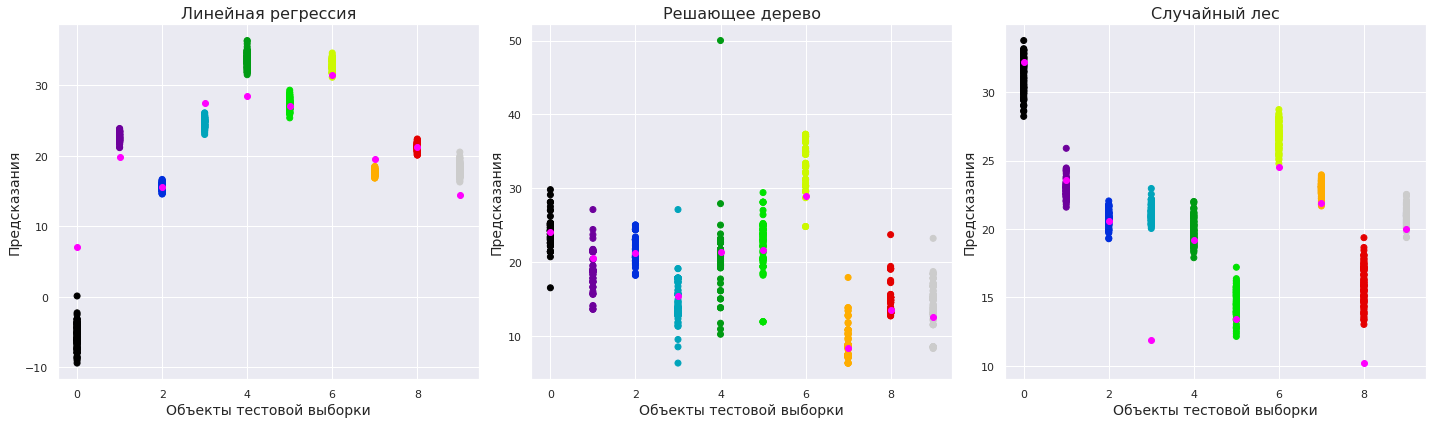

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

plot_predictions(regressor=LinearRegression(), X=X, y=y, num_runs=100, num_test_objects=10, title="Линейная регрессия", ax=ax1)

plot_predictions(regressor=DecisionTreeRegressor(), X=X, y=y, num_runs=100, num_test_objects=10, title="Решающее дерево", ax=ax2)

plot_predictions(regressor=RandomForestRegressor(), X=X, y=y, num_runs=100, num_test_objects=10, title="Случайный лес", ax=ax3)

plt.tight_layout()
plt.show()


Это реально самая лучшая cmap, которую я смогла найти (в остальных цвета были слишком похожи между собой). Так что, извиняюсь, но точки пришлось сделать другого цвета. 

(Розовый на красном видно всяко лучше, чем черный на черном, знаете ли...)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Так, ну давайте попробуем.
У нас, конечно, весьма ущербные мишени...
В нашем случае "столбики" из точек - предсказания модели, а розовые точки - верные ответы. Таким образом можно заметить, что чем столбики длинее, тем больше разброс модели - то есть тем более чувствительна модель к выборке, а значит на разных выборках она выдает двольно разные ответы. Как можно видеть, наибольший разброс имеет решающее дерево - на графике его предсказаний самые длинные столбцы. Самые короткие - у линейной регрессии. Что согласуется с полученными выше данными о разбросе для алгоритмов бэггинга.

Смещение - это отклонение среднего ответа от идеального. То есть если сдвиг большой, то (ну тут не "если, то", а следствие в две стороны, но энивей), то в среднем точки не совпадают с точкой, отвечающей за верное ответ. Как можно видеть, у линейной регрессии для большей части объектов выборки "верная" точка вообще не лежит на столбце, что значит, что ни одно предсказание модели не являлось верным, соответственно и в среднем оно не совпадает, а значит сдвиг большой. У решающего дерева все "верные" точки лежат на столбцах, что значит, что в среднем прогноз модели ближе в верному, а значит смещение меньше (но все равно не очень маленькое, так как "верные" точки в основном на краях столбцов, а очевидно смещение самое маленькое, когда эти точки лежат ровно по центру столбцов, ну или же вообще сам столбец является одной точкой). Ну а у случайного леса 2 "верные" точки не лажат на столбцах, что говорит о том, что смещение модели больше, чем у решающего дерева, но меньше, чем у линейной регрессии. Такие результаты тоже согласуются с тем, что было получено в пункте выше.

(Тут больше речь шла об относительных результатах, а не о точных, потому что ясно, что точные резы нашего так сказать "бэггинга" при построении графика и встроенного бэггинга не совпадают)

Вот так вот :)


 



### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [ ]:
m_depth = np.arange(1, 11)
bias_dt_1 = []
var_dt_1 = []

for d in m_depth:
    res_dt = compute_biase_variance(regressor=DecisionTreeRegressor(max_depth=d), X=X, y=y, num_runs=1000)

    bias_dt_1.append(res_dt[0])
    var_dt_1.append(res_dt[1])

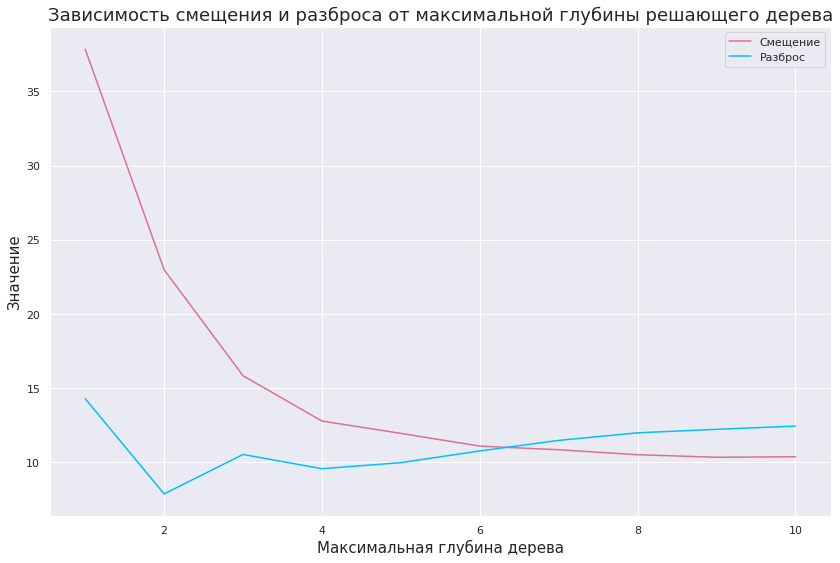

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(m_depth, bias_dt_1, c='palevioletred', label='Смещение')
plt.plot(m_depth, var_dt_1, c='deepskyblue', label='Разброс')
 
plt.xlabel('Максимальная глубина дерева', size=15)
plt.ylabel('Значение', size=15)
plt.title('Зависимость смещения и разброса от максимальной глубины решающего дерева', size=18)

plt.legend()
plt.show()

In [ ]:
m_features = np.arange(1, X.shape[1] + 1)
bias_dt_2 = []
var_dt_2 = []

for f in m_features:
    res_dt = compute_biase_variance(regressor=DecisionTreeRegressor(max_features=f), X=X, y=y, num_runs=1000)

    bias_dt_2.append(res_dt[0])
    var_dt_2.append(res_dt[1])


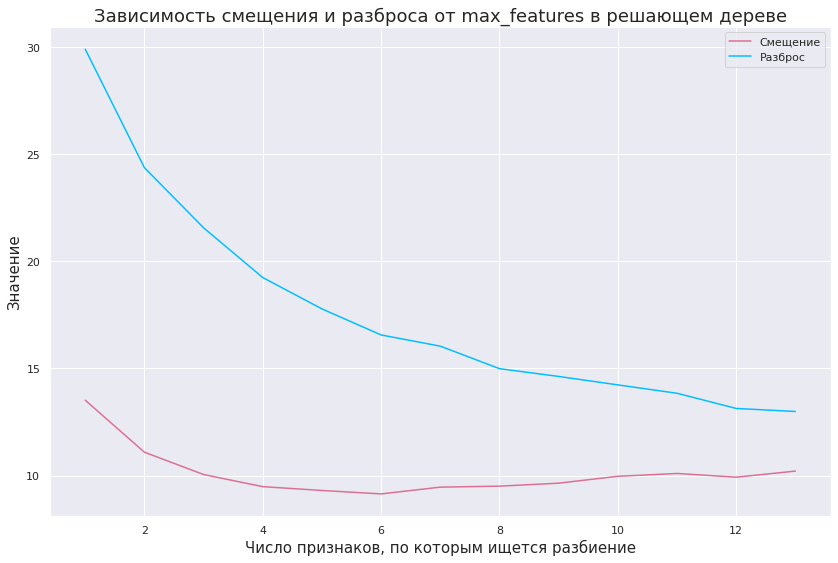

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(m_features, bias_dt_2, c='palevioletred', label='Смещение')
plt.plot(m_features, var_dt_2, c='deepskyblue', label='Разброс')
 
plt.xlabel('Число признаков, по которым ищется разбиение', size=15)
plt.ylabel('Значение', size=15)
plt.title('Зависимость смещения и разброса от max_features в решающем дереве', size=18)

plt.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
 from sklearn.ensemble import GradientBoostingRegressor
 import time

In [ ]:
grid = 2**np.arange(1, 10)
bias_rf = []
var_rf = []
start_time = time.time()

i = 1
for el in grid:
    print('К итарации №', i, 'времени прошло:', time.time() - start_time, 'секунд')  #в прошлый раз оно считалось 9 часов (мой косяк), так что мне жизненно нужна отладочная печать, простите...
    res_rf = compute_biase_variance(regressor=RandomForestRegressor(n_estimators=el), X=X, y=y, num_runs=1000)

    bias_rf.append(res_rf[0])
    var_rf.append(res_rf[1])

    i += 1

print('Итого времени ушло на вычисления:', time.time() - start_time, 'секунд')

К итарации № 1 времени прошло: 0.0001327991485595703 секунд
К итарации № 2 времени прошло: 12.212658882141113 секунд
К итарации № 3 времени прошло: 28.33721399307251 секунд
К итарации № 4 времени прошло: 59.86504030227661 секунд
К итарации № 5 времени прошло: 119.55264115333557 секунд
К итарации № 6 времени прошло: 236.04675889015198 секунд
К итарации № 7 времени прошло: 470.53427815437317 секунд
К итарации № 8 времени прошло: 933.2694365978241 секунд
К итарации № 9 времени прошло: 1849.3230996131897 секунд
Итого времени ушло на вычисления: 3686.0077114105225 секунд


In [ ]:
print(bias_rf)  #это на случай, если я вдруг случайно запущу предыдущую ячейку снова
print()
print(var_rf)

[10.586867256640273, 10.636558836775833, 10.486186547024825, 10.815779754393937, 10.672905932131831, 10.644301671914368, 10.628249860499032, 10.735762383128906, 10.655978755036617]

[8.593011639947218, 5.317245969686883, 3.638230615774807, 2.9489215672618503, 2.5620490760702244, 2.3205415345859213, 2.2385822713064787, 2.2241342358562326, 2.1445770627983434]


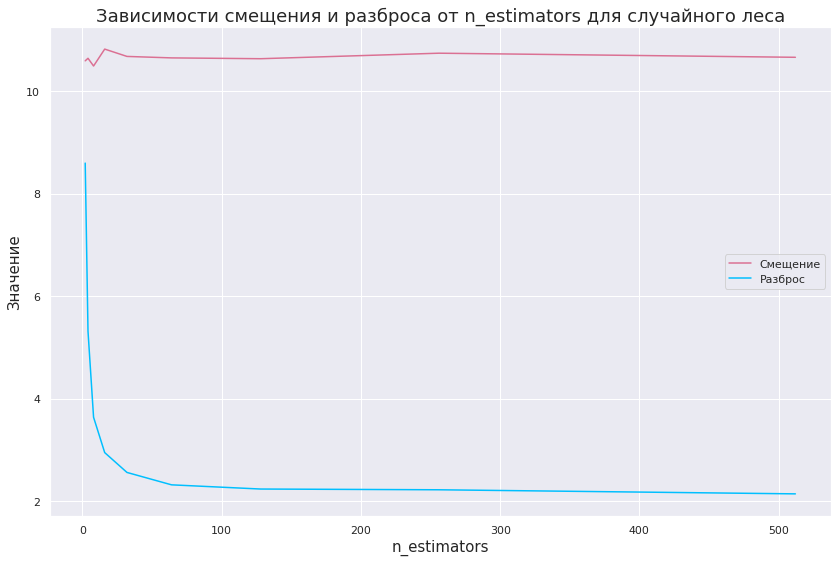

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(grid, bias_rf, c='palevioletred', label='Смещение')
plt.plot(grid, var_rf, c='deepskyblue', label='Разброс')
 
plt.xlabel('n_estimators', size=15)
plt.ylabel('Значение', size=15)
plt.title('Зависимости смещения и разброса от n_estimators для случайного леса', size=18)

plt.legend()
plt.show()

Кажется, в данном случае более наглядным будет график с логарифмическим xscale, так и сделаем.

In [ ]:
bias_gb = []
var_gb = []
start_time = time.time()

i = 1
for el in grid:
    print('К итарации №', i, 'времени прошло:', time.time() - start_time, 'секунд')  #в прошлый раз оно считалось 9 часов (мой косяк), так что мне жизненно нужна отладочная печать, простите...

    res_gb = compute_biase_variance(regressor=GradientBoostingRegressor(n_estimators=el), X=X, y=y, num_runs=1000)

    bias_gb.append(res_gb[0])
    var_gb.append(res_gb[1])

    i += 1

print('Итого времени ушло на вычисления:', time.time() - start_time, 'секунд')

К итарации № 1 времени прошло: 0.0002560615539550781 секунд
К итарации № 2 времени прошло: 3.8460700511932373 секунд
К итарации № 3 времени прошло: 10.35642385482788 секунд
К итарации № 4 времени прошло: 22.27741503715515 секунд
К итарации № 5 времени прошло: 44.94907069206238 секунд
К итарации № 6 времени прошло: 89.20714950561523 секунд
К итарации № 7 времени прошло: 177.25021600723267 секунд
К итарации № 8 времени прошло: 354.4556522369385 секунд
К итарации № 9 времени прошло: 716.780430316925 секунд
Итого времени ушло на вычисления: 1409.9905409812927 секунд


In [ ]:
print(bias_gb)
print()
print(var_gb)

[62.608956021617246, 47.28155650313861, 29.66150187507378, 16.356651006302233, 11.22346455128608, 9.51387583194369, 8.970181428144976, 8.883616962078442, 8.639945450150458]

[0.3913184156628739, 0.6668709268897922, 1.0464825115584984, 1.399988385486577, 1.7159176013841844, 1.930107862708469, 2.1299144822807348, 2.344992137066762, 2.447142833583124]


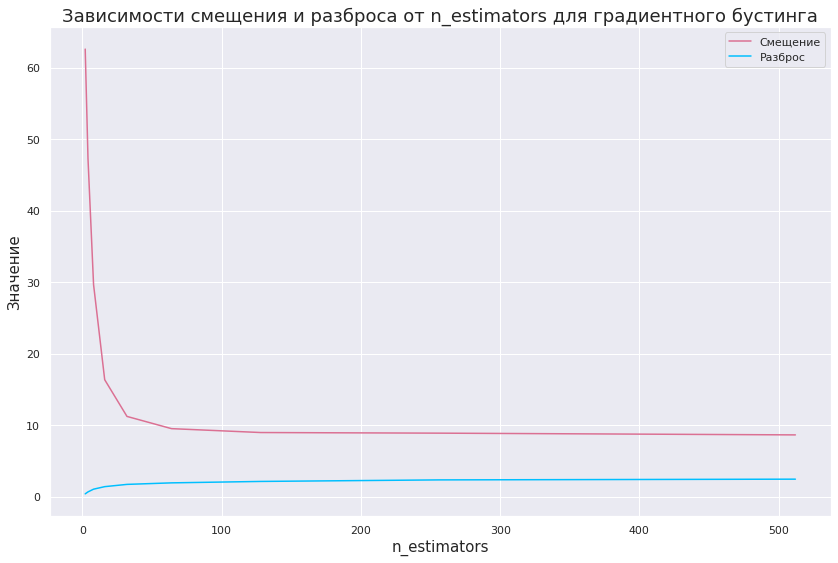

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(grid, bias_gb, c='palevioletred', label='Смещение')
plt.plot(grid, var_gb, c='deepskyblue', label='Разброс')
 
plt.xlabel('n_estimators', size=15)
plt.ylabel('Значение', size=15)
plt.title('Зависимости смещения и разброса от n_estimators для градиентного бустинга', size=18)

plt.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Чтобы не писать каждый раз названия графиков - буду писать их порядковй номер (1-4).

1. Зависимость смещения и разброса от максимальной глубины решающего дерева

Смещение падает, разброс сначала немного падает, затем медленно растет. 

Так, ну чем больше глубина решающего дерева, тем более сильно оно подгоняется под исходную выборку (более подробно писала об этом в прошлом дз), таким образом при увеличении глубины дерева возрастает возможность переобучения (способность к переобучению, не знаю, как это правильнее назвать). Таким образом смешение падает, так как качество прогнозов увеличивается. А как мы помним, смещение характерезует богатство семейства моделей, то есть чем лучше модель, тем меньше смещение. Разброс же сначала немного падает, а затем наоборот немного растет. Как мы помним, он характеризует чувствительность модели к изменениям обучающей выборки (чем больше чувствительность - тем больше разброс). Очевидно, что при рассмотрении дерева глубины 2 относительно дерева глубины 1 чувствительность будет ниже, так как при разделении исходных данных на две части более сильно ощущается влияние исходной выборки на выбор. А далее уже при увеличении глубины дерева чувствительность немного растет, так как грубо говоря растет подгон под изначальные данные и выбор лучшего разбиения на каждом шаге решающего дерева уже сильнее зависит от них.

2. Зависимость смещения и разброса от max_features в решающем дереве

Разброс падает, смешение сначала немного падает, затем медленно растет.

max_features - это количество признаков, которые рассматривает решающее дерево (для построения best split, судя по документации). Значит логично предположить, что чем больше рассматривается признаков, тем модель менее чувствительна к измененям обучающей выборки (каждый элемент какого-то по отдельности не так сильно влияет на работу модели, так как вероятность того, что разбиение будет происходить по этому признаку меньше). А значит разброс модели падает. 

Тут: https://www.machinelearningmastery.ru/how-to-tune-a-decision-tree-f03721801680/ пишет, что max_features регулирует перенасышение, и настроив оптимальное значение можно улучшить стабильность модели. Вспомним, что чем более стабильная у нас модель, тем меньше разброс. Этим можно объяснить то, что в начале у нас смещение падает, а потом очень медленно растет. Растет оно так как модель становится немного менее стабильной с увеличением max_features.

3. Зависимости смещения и разброса от n_estimators для случайного леса

Смещение почти не меняется, разброс сначала сильно падает, потом почти не меняется

Как мы помним, n_estimators - это количество деревье в случайном лесу. На лекции говорилось, что случайный лес по сути является бэггингом над деревьями и также говорилось то, что при бэггинге смещение не меняется. Так что совместим 2 этих факта и сошлемся на них. (Да и собственно логично, с чего бы друг смещению меняться). А вот разброс, как я уже и писаа в предыдущих номерах, при бэггинге уменьшается в количество раз равное n_estimators в слчае если модели не коррелированы, и меньше, если коррелированы. В случае случайного леса в конспектах пишет, что он очень старается снизить корреляцию между деревьями, так что разброс уменьшается 
довольно сильно

4. Зависимости смещения и разброса от n_estimators для градиентного бустинга

Разброс почти не меняется, смещение сначала сильно падает, потом почти не меняется

На лекции говорилось, что благодаря бустингу можно понизить смещение моделей, а разброс либо останется таким же, либо увеличится. И из-за этого в бустинге используют неглубокие решающие деревья (дефолтно глубины 3), которые обладают большим смещением и не склонны к переобучению. 

Как мы видим, при увеличении n_estimators разброс действительно почти не меняется (немножко увеличивается), а вот смещение сильно падает. Ну а уменьшение смещения объяснимо тем, что так как градиентный бустинг устойчив к переобучению (Соколов не может врать, я считаю), то чем больше шагов градиентного бустинга мы делаем, тем лучше получаем результата, а значит тем меньше будет смещение. 

На это раз мем будет жизненным и грустным

Это список моих дедлайнов

Можете нервно посмеяться вместе со мной 🙃🙃🙃

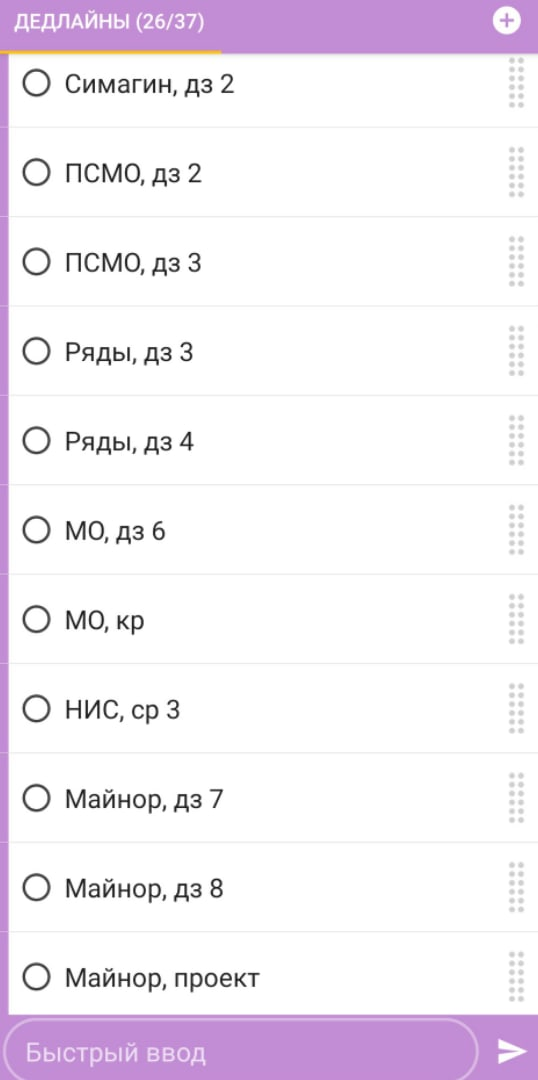

Как говорится, счастья, удачи, здоровья!!!!